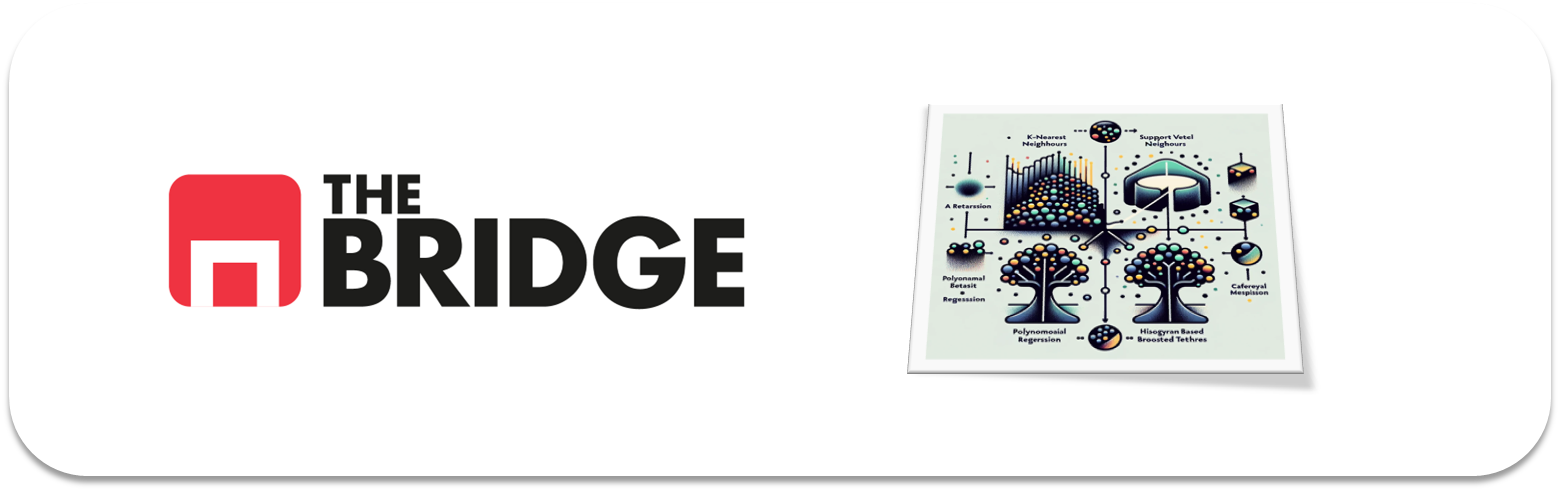

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE


import bootcampviztools as bt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

def get_cardinality(df:pd.DataFrame, threshold_categorical=10, threshold_continuous=30):
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Expected a pandas DataFrame")
    
    print('pandas.DataFrame shape: ', df.shape)
    
    df_out = pd.DataFrame([df.nunique(), df.nunique()/len(df) * 100, df.isna().sum(), df.dtypes])
    df_out = df_out.T.rename(columns = {0: 'Cardinality', 1: '%_Card', 2: 'NaN_Values', 3: 'Type'})
    
    df_out.loc[df_out['Cardinality'] < threshold_categorical, 'Class'] = 'Categoric'    
    df_out.loc[df_out['Cardinality'] == 2, 'Class'] = 'Binary'
    df_out.loc[df_out['Cardinality'] >= threshold_categorical, 'Class'] ='Numeric - Discrete'
    df_out.loc[df_out['%_Card'] > threshold_continuous, 'Class'] = 'Numeric - Continuous'
    
    return df_out

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [2]:
df = pd.read_csv("./data/credit_npo.csv")

In [3]:
df.sample(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
10693,0,1.000000,41,0,0.220283,10599.0,1,0,1,0,2.0
7009,0,0.002058,55,1,0.277367,11500.0,15,0,2,0,2.0
1986,0,0.000000,55,0,0.212841,6525.0,8,0,1,0,4.0
2062,0,0.019393,50,0,0.165246,40000.0,15,0,1,0,3.0
29,0,0.000000,50,0,0.000000,NaN,13,0,0,0,0.0
10376,0,0.003558,72,0,0.049805,10500.0,8,0,2,0,0.0
10347,0,0.139888,59,0,0.482869,7500.0,14,0,2,0,1.0
2905,0,0.718984,46,0,0.155425,3750.0,5,0,0,0,1.0
3022,0,0.046462,74,0,0.012289,8950.0,8,0,0,0,0.0
2791,0,0.899982,58,4,1.195652,2253.0,11,0,1,0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [5]:
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(df['NumberOfDependents'].median())
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())

In [6]:
get_cardinality(df, threshold_categorical=10, threshold_continuous=30)

pandas.DataFrame shape:  (12537, 11)


,Cardinality,%_Card,NaN_Values,Type,Class
SeriousDlqin2yrs,2,0.015953,0,int64,Binary
RevolvingUtilizationOfUnsecuredLines,10764,85.857861,0,float64,Numeric - Continuous
age,78,0.622158,0,int64,Numeric - Discrete
NumberOfTime30-59DaysPastDueNotWorse,10,0.079764,0,int64,Numeric - Discrete
DebtRatio,11547,92.103374,0,float64,Numeric - Continuous
MonthlyIncome,4167,33.237617,0,float64,Numeric - Continuous
NumberOfOpenCreditLinesAndLoans,43,0.342985,0,int64,Numeric - Discrete
NumberOfTimes90DaysLate,13,0.103693,0,int64,Numeric - Discrete
NumberRealEstateLoansOrLines,16,0.127622,0,int64,Numeric - Discrete
NumberOfTime60-89DaysPastDueNotWorse,8,0.063811,0,int64,Categoric


### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

In [7]:
target = "SeriousDlqin2yrs"

Es un problema de clasificación

### #1.3
Pinta la distribución de frecuencias del target y coméntala

<Axes: xlabel='SeriousDlqin2yrs', ylabel='count'>

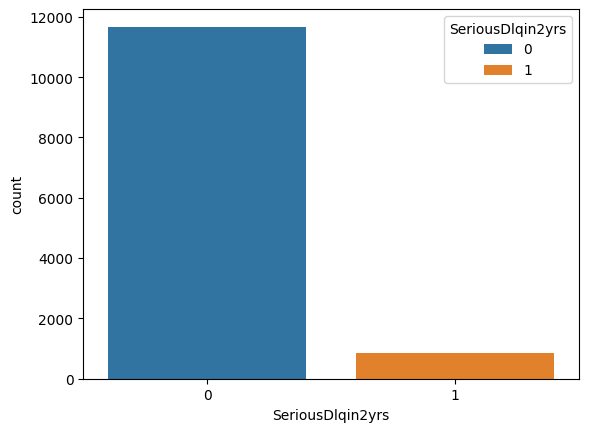

In [8]:
sns.countplot(x = target, data = df, hue = target)

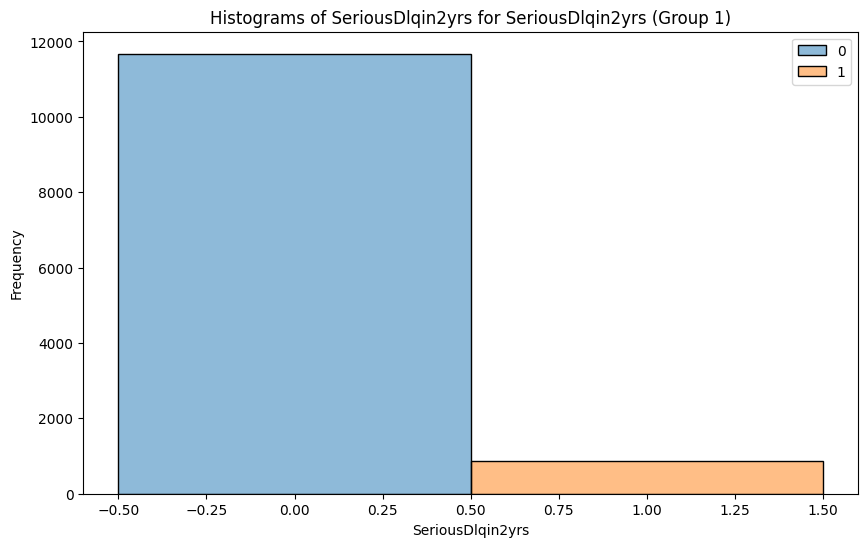

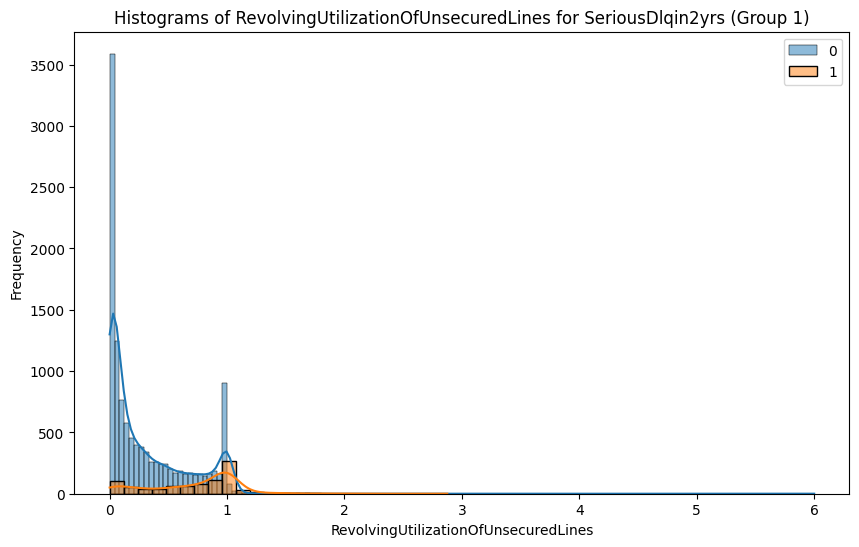

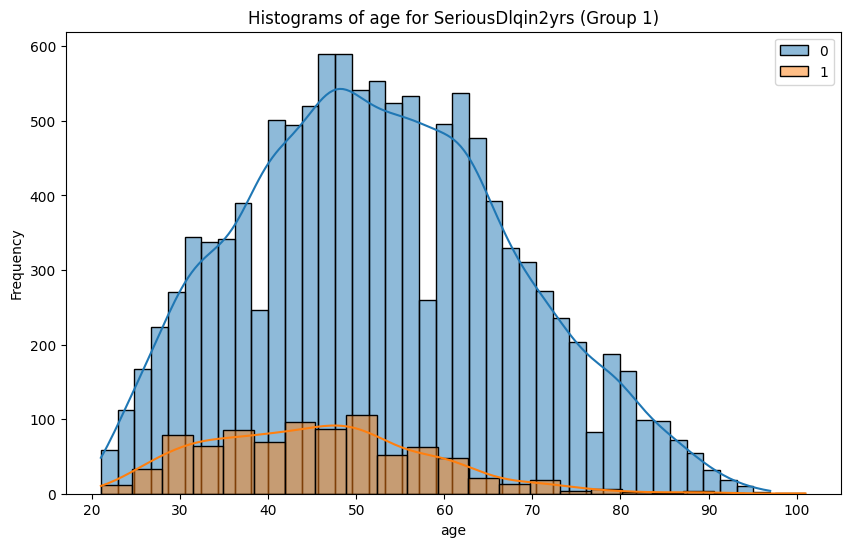

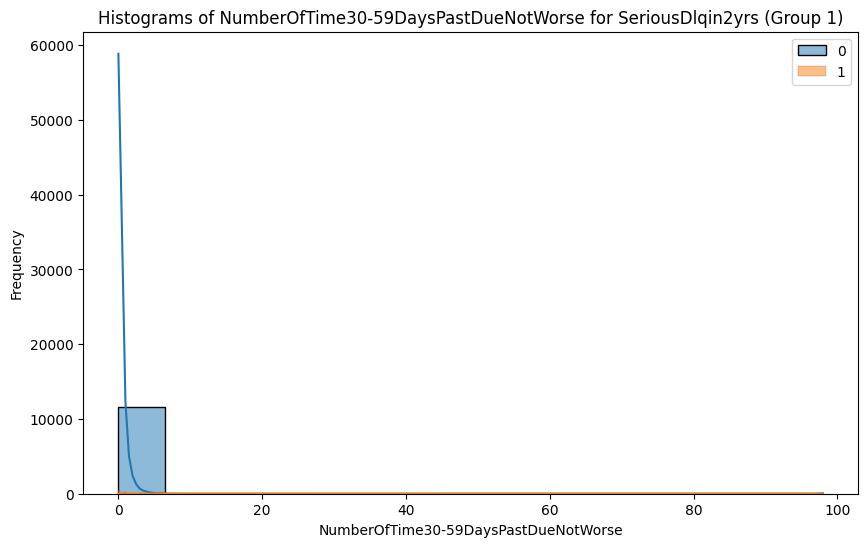

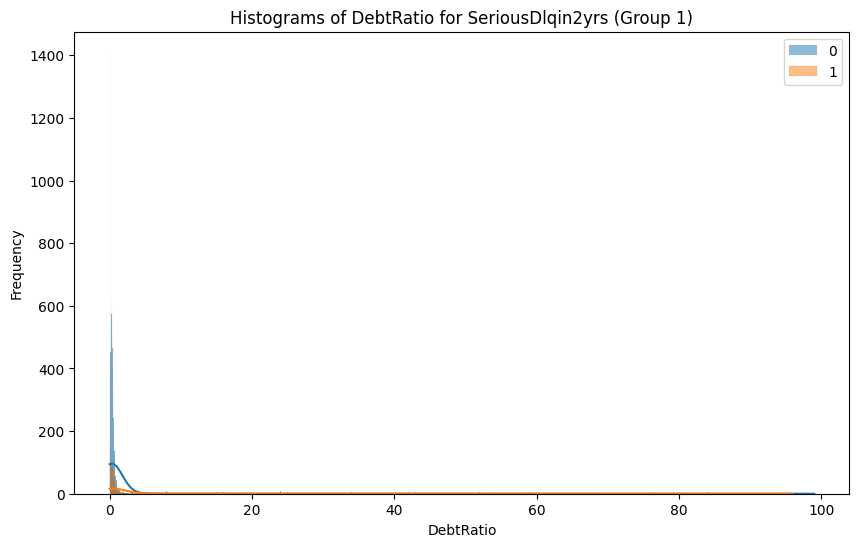

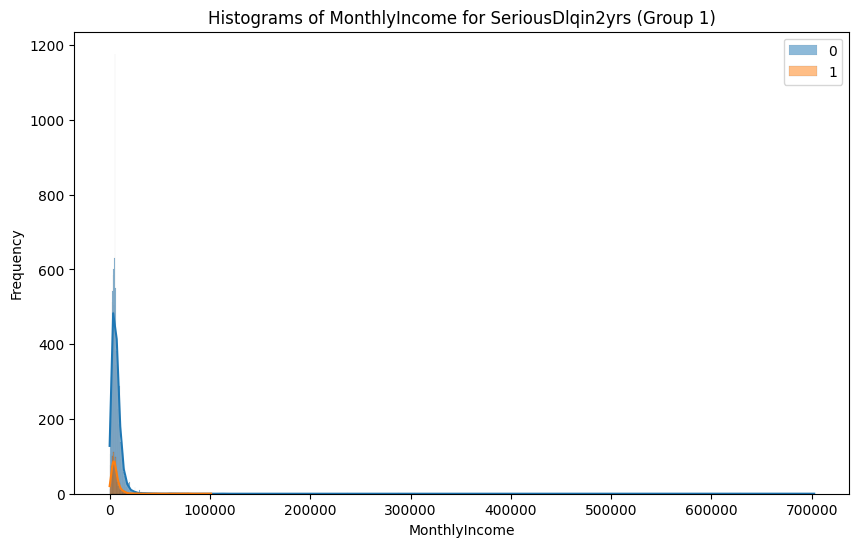

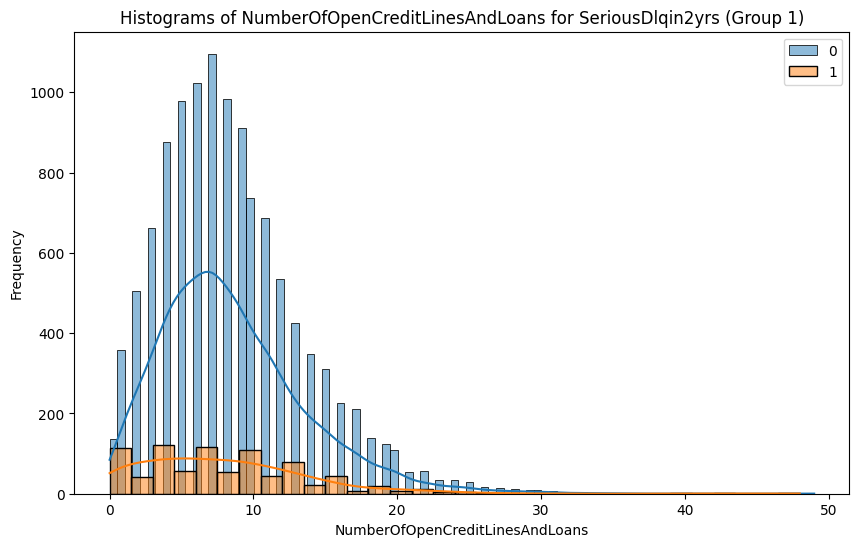

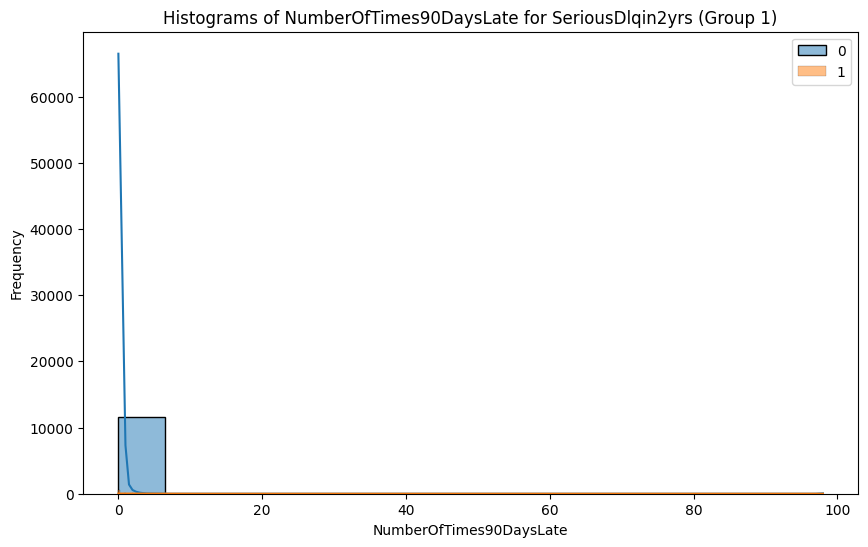

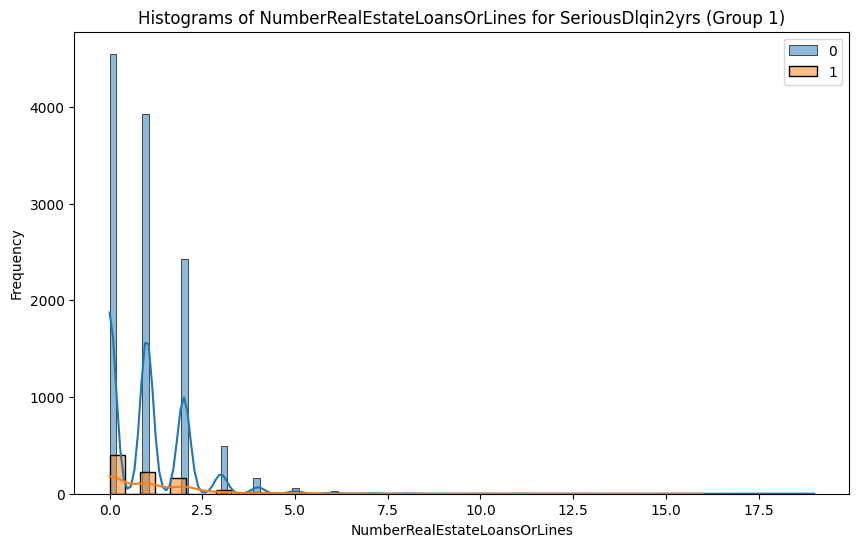

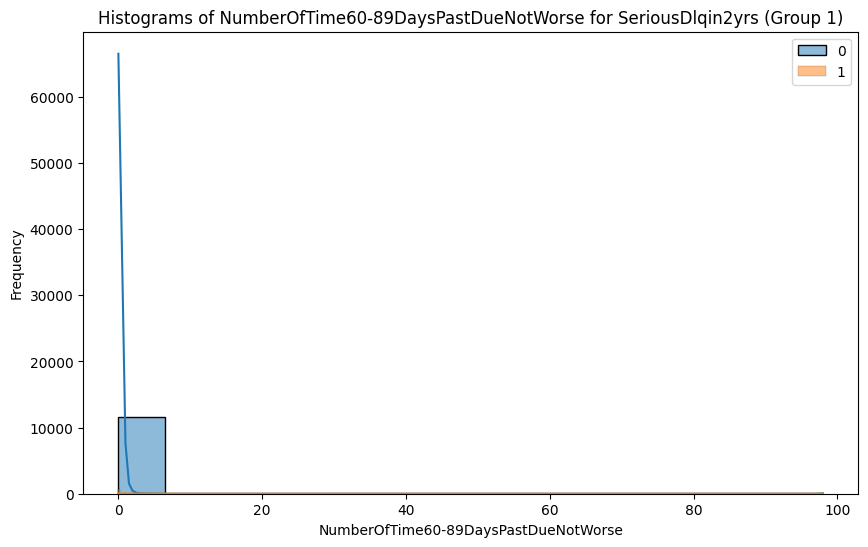

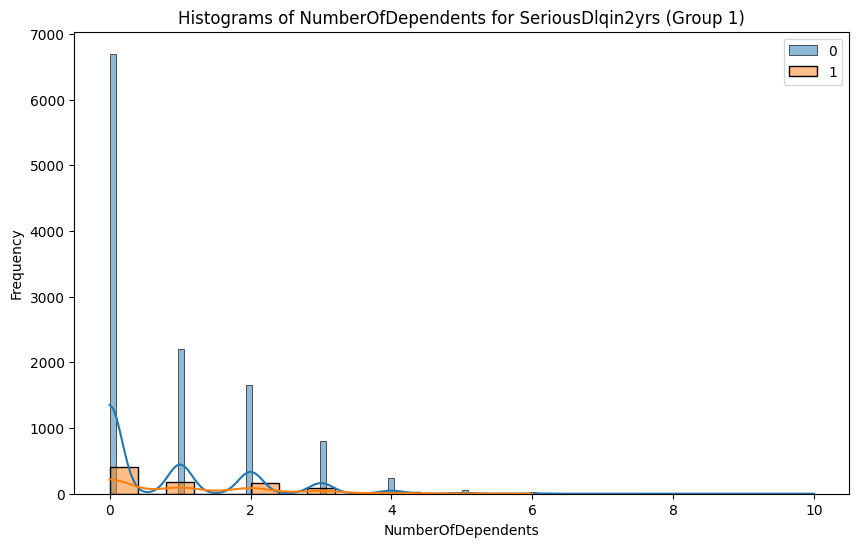

In [9]:
for col in df:
    bt.plot_grouped_histograms(df, target, col, group_size=3)

<Axes: >

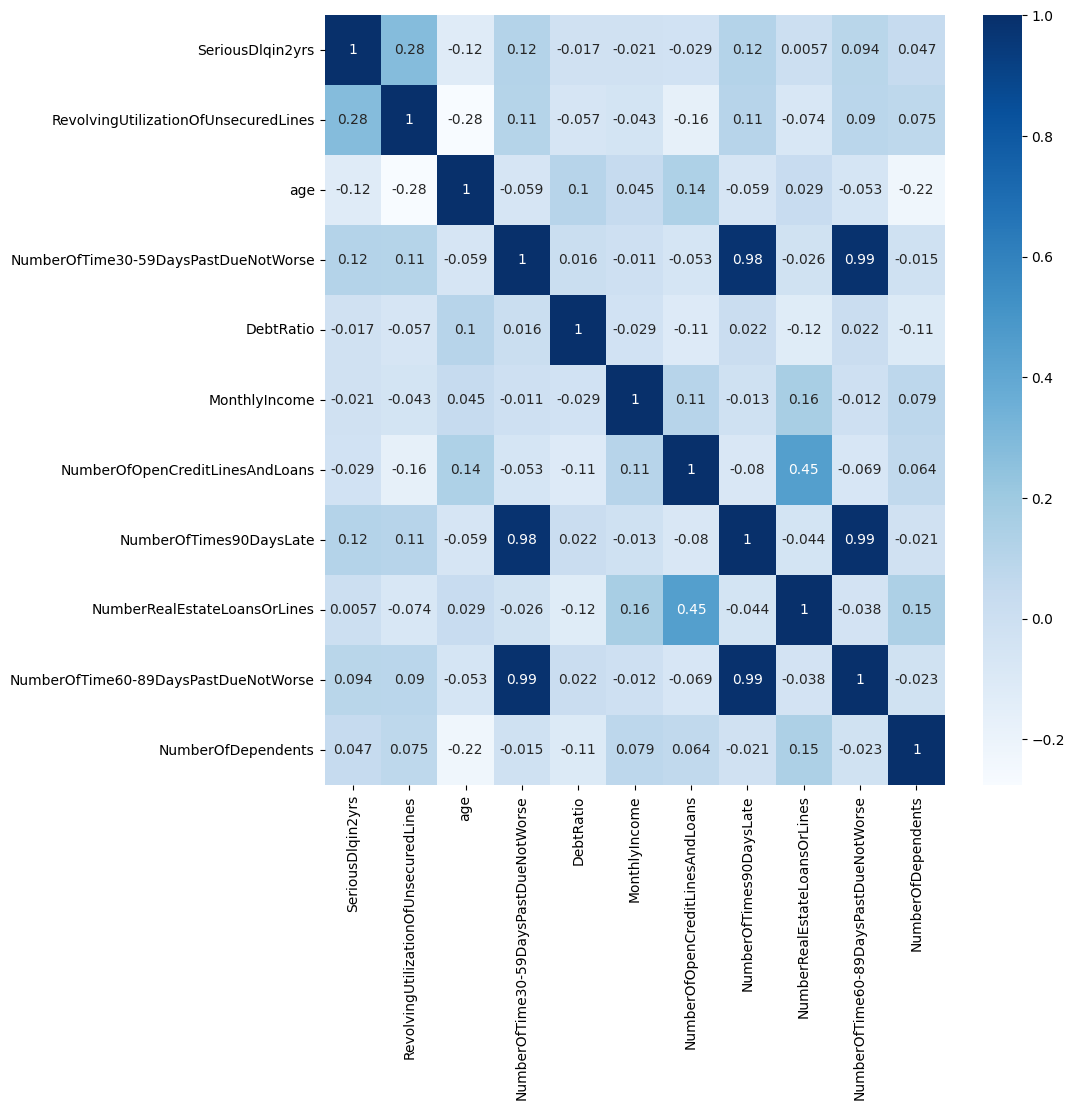

In [10]:
corr = df.corr(numeric_only= True)

import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
sns.heatmap(corr, annot = True, cmap = "Blues")

In [11]:
df = df.drop(["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "NumberOfOpenCreditLinesAndLoans"], axis=1)

In [12]:
'''for col in train_set:
    bt.plot_grouped_histograms(train_set, target, col, group_size=2)'''

'for col in train_set:\n    bt.plot_grouped_histograms(train_set, target, col, group_size=2)'

In [13]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
features = train_set.columns.drop(target)

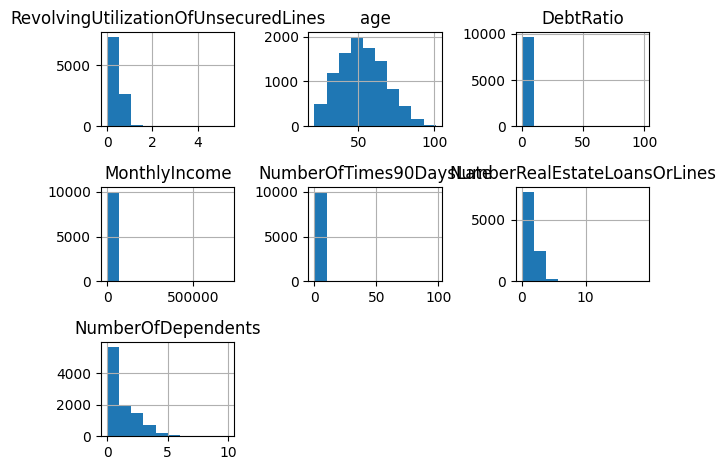

In [15]:
train_set[features].hist()
plt.tight_layout()

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

In [16]:
features

Index(['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
       'MonthlyIncome', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfDependents'],
      dtype='object')

In [17]:
scaler = StandardScaler()

# Adaptamos el StandarScaler al X_train, pero luego usamos el mismo en el X_test (porque ya la media y la desviación son las del X_train)		
train_set[features] = scaler.fit_transform(train_set[features])
test_set[features] = scaler.transform(test_set[features])

In [18]:
X_train = train_set.drop([target], axis=1) 
y_train = train_set[target]
X_test = test_set.drop([target], axis=1)
y_test = test_set[target]

In [19]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#### 1.1 Modelo con Regresión logística con class_weight

In [20]:
print ("TRAIN")
log_reg = LogisticRegression(max_iter = 25000, class_weight="balanced")
log_reg.fit(X_train, y_train)
train_pred = log_reg.predict(X_train)
print(classification_report(y_train, train_pred))

print ("TEST")
test_pred = log_reg.predict(X_test)
print(classification_report(y_test, test_pred))

print ("SMOTE")
modelo_smote = LogisticRegression(max_iter = 25000)
modelo_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = modelo_smote.predict(X_test)
print(classification_report(y_test, y_pred_smote))

TRAIN
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      9328
           1       0.19      0.74      0.30       701

    accuracy                           0.76     10029
   macro avg       0.58      0.75      0.57     10029
weighted avg       0.92      0.76      0.81     10029

TEST
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      2345
           1       0.18      0.73      0.29       163

    accuracy                           0.76      2508
   macro avg       0.58      0.75      0.57      2508
weighted avg       0.92      0.76      0.82      2508

SMOTE
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      2345
           1       0.18      0.72      0.28       163

    accuracy                           0.76      2508
   macro avg       0.58      0.74      0.57      2508
weighted avg       0.92      0.76      0.82      2508



#### 2. Modelo con Árbol de decisión

In [21]:
print ("TRAIN")
tree_class = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight="balanced")
tree_class.fit(X_train, y_train)
train_pred = tree_class.predict(X_train)
print(classification_report(y_train, train_pred))

print ("TEST")
test_pred = tree_class.predict(X_test)
print(classification_report(y_test, test_pred))

print ("SMOTE")
modelo_smote = DecisionTreeClassifier(max_depth=5, random_state=42)
modelo_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = modelo_smote.predict(X_test)
print(classification_report(y_test, y_pred_smote))

TRAIN
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      9328
           1       0.19      0.80      0.31       701

    accuracy                           0.75     10029
   macro avg       0.59      0.77      0.58     10029
weighted avg       0.93      0.75      0.81     10029

TEST
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      2345
           1       0.16      0.72      0.26       163

    accuracy                           0.74      2508
   macro avg       0.57      0.73      0.55      2508
weighted avg       0.92      0.74      0.80      2508

SMOTE
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      2345
           1       0.16      0.68      0.27       163

    accuracy                           0.76      2508
   macro avg       0.57      0.72      0.56      2508
weighted avg       0.92      0.76      0.81      2508



#### 3. Modelo con Random Forest

In [22]:
print ("TRAIN")
rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=42, class_weight="balanced")
rnd_clf.fit(X_train, y_train)
train_pred = rnd_clf.predict(X_train)
print(classification_report(y_train, train_pred))

print ("TEST")
test_pred = rnd_clf.predict(X_test)
print(classification_report(y_test, test_pred))

print ("SMOTE")
modelo_smote = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=42)
modelo_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = modelo_smote.predict(X_test)
print(classification_report(y_test, y_pred_smote))

TRAIN
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      9328
           1       0.21      0.76      0.33       701

    accuracy                           0.78     10029
   macro avg       0.59      0.77      0.60     10029
weighted avg       0.92      0.78      0.83     10029

TEST
              precision    recall  f1-score   support

           0       0.97      0.78      0.87      2345
           1       0.18      0.67      0.28       163

    accuracy                           0.78      2508
   macro avg       0.57      0.73      0.57      2508
weighted avg       0.92      0.78      0.83      2508

SMOTE
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      2345
           1       0.19      0.66      0.29       163

    accuracy                           0.79      2508
   macro avg       0.58      0.73      0.58      2508
weighted avg       0.92      0.79      0.84      2508



#### 4. Modelo con KNN

In [23]:
print ("TRAIN")
knn = KNeighborsClassifier(n_neighbors=5)  		#Un n_neighbors bajo hace que sobreajuste: menos varianza (menos validation error), a costa de más training error
knn.fit(X_train,y_train)
prediccion = knn.predict(train_set[['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
       'MonthlyIncome', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfDependents']])
print(classification_report(y_train, prediccion))

print ("TEST")
prediccion = knn.predict(test_set[['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
       'MonthlyIncome', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfDependents']])
print(classification_report(y_test, prediccion))



print ("SMOTE")
modelo_smote = KNeighborsClassifier(n_neighbors=5)
modelo_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = modelo_smote.predict(X_test)
print(classification_report(y_test, y_pred_smote))

TRAIN
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      9328
           1       0.77      0.20      0.32       701

    accuracy                           0.94     10029
   macro avg       0.86      0.60      0.64     10029
weighted avg       0.93      0.94      0.92     10029

TEST
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2345
           1       0.48      0.14      0.22       163

    accuracy                           0.93      2508
   macro avg       0.71      0.57      0.59      2508
weighted avg       0.91      0.93      0.92      2508

SMOTE
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      2345
           1       0.15      0.47      0.23       163

    accuracy                           0.80      2508
   macro avg       0.55      0.64      0.56      2508
weighted avg       0.90      0.80      0.84      2508



Nos quedamos con Árbol de Clasificación y ajustamos hiperparámetros